In [ ]:
#Import the necessary libraries(This was run on Kaggle as Colabs was crashing and getting disconnected)
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ratings = pd.read_csv("/content/drive/MyDrive/MLNS/ratings_music.csv")

#Exploratory Data Analysis

In [ ]:
ratings.shape

(318485, 3)

In [ ]:
ratings.dtypes

userID       object
productID    object
Rating        int64
dtype: object

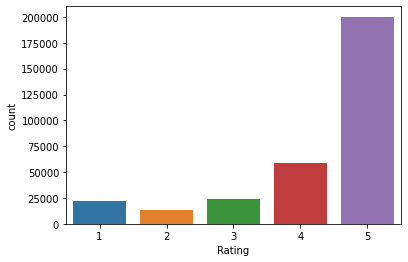

In [ ]:
#Countplot of the ratings, maximum user-products have got rating as 5 
sns.countplot(data=ratings, x='Rating');

In [ ]:
#Find the minimum and maximum ratings - It is between 1 and 5
print('Minimum rating is: %d' %(ratings.Rating.min()))
print('Maximum rating is: %d' %(ratings.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [ ]:
#Check for missing values - There are no missing values, so no imputation required
print('Number of missing values across columns: \n',ratings.isna().sum())

Number of missing values across columns: 
 userID       0
productID    0
Rating       0
dtype: int64


In [ ]:
#Number of products (4897) is less than number of users(8208), so item-item colaborative filtering would make sense
#instead of user-user colaborative filtering
print("Music Data Summary")
print("\nTotal # of Ratings :",ratings.shape[0])
print("Total # of Users   :", len(np.unique(ratings.userID)))
print("Total # of Products  :", len(np.unique(ratings.productID)))
print("\n")

Music Data Summary

Total # of Ratings : 318485
Total # of Users   : 8208
Total # of Products  : 4897




In [ ]:
#for consistency we remove duplicates
ratings.drop_duplicates(inplace=True)

In [ ]:
#Analysis of how many product rating given by a particular user 
no_of_rated_products_per_user = ratings.groupby(by='userID')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

userID
ATVPDKIKX0DER     9797
A3UN6WX5RRO2AG    4099
A9Q28YTLYREO7      721
A1GN8UJIZLCA59     556
A1J5KCZC8CMW9I     506
Name: Rating, dtype: int64

In [ ]:
no_of_rated_products_per_user.describe().astype(int).T

count    8208
mean       24
std       120
min         1
25%        11
50%        15
75%        23
max      9797
Name: Rating, dtype: int64

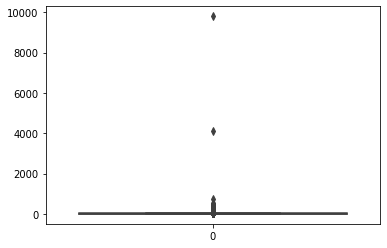

In [ ]:
#Boxplot shows that we have few users who rate many items (appearing in outliers) but majority rate very few items
sns.boxplot(data=no_of_rated_products_per_user);

In [ ]:
#We have only 611 users who have rated more than or equal to 50 products
print('\n Users that rated more then 50 products : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 Users that rated more then 50 products : 611



In [ ]:
#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=ratings.groupby("userID").filter(lambda x:x['Rating'].count() >=50)
new_df.head()

,userID,productID,Rating
0,ATVPDKIKX0DER,B0000262WI,5
10,A9Q28YTLYREO7,B0000262WI,5
15,A1RJJ56MBJMX87,B0000262WI,4
19,ATVPDKIKX0DER,B000002NH0,5
22,ATVPDKIKX0DER,B000002NH0,4


In [ ]:
#Products also have skewed ratings with majority of the products having very few ratings
no_of_ratings_per_product = new_df.groupby(by='productID')['Rating'].count().sort_values(ascending=False)


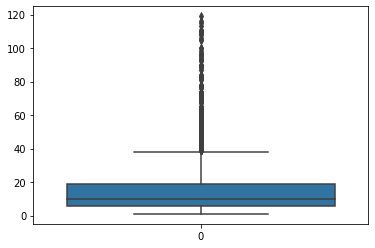

In [ ]:
#Boxplot shows that we have few products with large number of ratings, but majority have very low ratings
sns.boxplot(data=no_of_ratings_per_product);

In [ ]:
#Average rating of the product across users
new_df.groupby('productID')['Rating'].mean().sort_values(ascending=False).head()

productID
B00004Y6TM    5.0
B00006JIA5    5.0
B000002HM9    5.0
B00006J402    5.0
B00005ATIH    5.0
Name: Rating, dtype: float64

In [ ]:
#Total # of ratings for product
new_df.groupby('productID')['Rating'].count().sort_values(ascending=False).head()

productID
B000002UAT    119
B000002UAV    116
B000002UAU    115
B000002J0A    113
B000002J09    111
Name: Rating, dtype: int64

In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productID')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productID')['Rating'].count())
#Products which have high rating have fewer user reviews as seen below
ratings_mean_count.head()

,Rating,rating_counts
productID,,
1570420521,4.333333,6
1570420572,4.666667,3
9626340959,3.000000,8
9626341041,3.454545,11
9626346175,3.000000,10


In [ ]:
#The maximum number of ratings received for a product is 119
ratings_mean_count['rating_counts'].max()

119

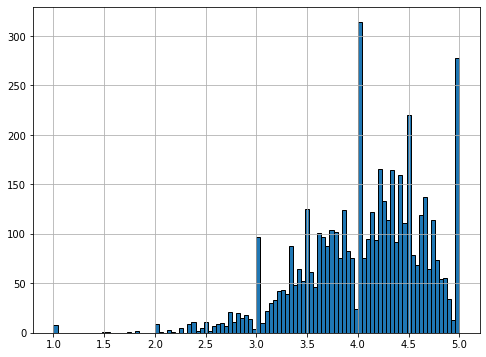

In [ ]:
#We see a left skewed distribution for the ratings
#There are clusters at each of the points 1,2,3,4,5 as that is where the means are concentrated
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=100)

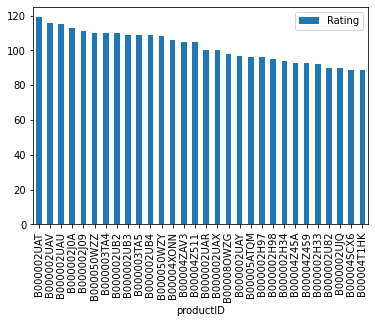

In [ ]:
#Below is the bar graph showing product list of top 30 most popular products
popular_products = pd.DataFrame(new_df.groupby('productID')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

#Collaborative filtering (Item-Item)


In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630229 sha256=6533dc343934b6be208fb784ce59315a807d74815fb1b09bdf97be0095e543a5
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [ ]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [ ]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [ ]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [ ]:
test_pred

In [ ]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.1669


1.166902862170905

#Collaborative Filtering (model based)

In [ ]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userID', columns='productID', fill_value=0)
ratings_matrix.head()

productID,B00000098J,B000000H60,B000000NFJ,B000000OA6,B000000OA8,B000000OAC,B000000OAE,B000000OAH,B000000OAJ,B000000OAL,...,B00008VOQM,B00008W2OO,B0000931OG,B0000931OL,B0000931OT,B000093U1G,B000095J7Q,B00009KTZM,B00009LI14,B00009MV2M
userID,,,,,,,,,,,,,,,,,,,,,
A103KNDW8GN92L,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0
A105S56ODHGJEK,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0
A10DNCYK7YISHU,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0
A10XJR7CWHNKWU,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0
A1143SNKOV0ZIT,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0


In [ ]:
ratings_matrix.shape

(609, 695)

In [ ]:
#Transpose the matrix
X = ratings_matrix.T
X

userID,A103KNDW8GN92L,A105S56ODHGJEK,A10DNCYK7YISHU,A10XJR7CWHNKWU,A1143SNKOV0ZIT,A11H85UYL2R4KX,A11NKZ57YSELZC,A11XKY4EIU2KNR,A12AQEM8MAW2LC,A12CNVNNX7NQ8U,...,AYT4YLB36MY4J,AYZCMVSSL4X4B,AZ1KR2Z1J4AXC,AZ35DRA4V3Q3T,AZ7LPCN9Y9SLJ,AZD7NEVKD2GBX,AZDL23124GWH3,AZDVOFC2MTIM5,AZKXH0J59TK11,AZSN1TO0JI87B
productID,,,,,,,,,,,,,,,,,,,,,
B00000098J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000000H60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000000NFJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000000OA6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000000OA8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B000093U1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000095J7Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00009KTZM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X1 = X

In [ ]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(695, 10)

In [ ]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(695, 695)

In [ ]:
X.index[75]

'B0000026TE'

In [ ]:
i = "B0000026TE"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [ ]:
#Correlation for all items with the item purchased by this customer based 
#on items rated by other customers people who bought the same product
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(695,)

In [ ]:
#Recommending top 25 highly correlated products in sequence
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['B000000WCA',
 'B000001EYW',
 'B0000028VT',
 'B000002G2R',
 'B000002H39',
 'B000002IXU',
 'B000002JL4',
 'B000002KY8',
 'B000002LKH',
 'B000002MY4',
 'B000002NHA',
 'B000002NHG',
 'B000002NJS',
 'B000002NJT',
 'B000002TLY',
 'B0000062VP',
 'B00000638L',
 'B000006OAN',
 'B000006OB0',
 'B000007WF4',
 'B00000AG8K',
 'B00000AG8R',
 'B00000AG8V',
 'B00000D9TQ']

#Popularity based

In [ ]:
#Split the data into 70% train and 30% test
train_data, test_data = train_test_split(new_df, test_size = 0.30, random_state=0)
print(train_data.head(5))


                userID   productID  Rating
158815  A2HH9D5UEDGE0S  B0000029F8       5
314114   ATVPDKIKX0DER  B0000027RL       5
86374   A1BJJVV2B5VLUQ  B000002J09       5
11040   A2NQUGGYM0DBM1  B00000EJ4B       5
114711  A2U0DKQPZSD50Y  B000050WZZ       5


In [ ]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productID').agg({'userID': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userID': 'score'},inplace=True)
train_data_grouped.head()

,productID,score
0,1570420521,4
1,1570420572,2
2,9626340959,5
3,9626341041,8
4,9626346175,7


In [ ]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productID'], ascending = [0,1])     
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productID,score,Rank
1249,B000002UB2,81,1.0
1243,B000002UAT,80,2.0
1474,B000003TA4,80,3.0
1244,B000002UAU,79,4.0
1245,B000002UAV,79,5.0


In [ ]:
# Use popularity based recommender model to make predictions for a user
# As we note this list will be same for all the users
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [ ]:
# This list a list of users (those that have commented the most but this is random) since this is popularity based recommendation method irrespective of user 
# same products will be suggested
find_recom = ['ATVPDKIKX0DER','A3UN6WX5RRO2AG','A9Q28YTLYREO7','A1GN8UJIZLCA59','A1J5KCZC8CMW9I']   
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: ATVPDKIKX0DER

             userId   productID  score  Rank
1249  ATVPDKIKX0DER  B000002UB2     81   1.0
1243  ATVPDKIKX0DER  B000002UAT     80   2.0
1474  ATVPDKIKX0DER  B000003TA4     80   3.0
1244  ATVPDKIKX0DER  B000002UAU     79   4.0
1245  ATVPDKIKX0DER  B000002UAV     79   5.0


Here is the recommendation for the userId: A3UN6WX5RRO2AG

              userId   productID  score  Rank
1249  A3UN6WX5RRO2AG  B000002UB2     81   1.0
1243  A3UN6WX5RRO2AG  B000002UAT     80   2.0
1474  A3UN6WX5RRO2AG  B000003TA4     80   3.0
1244  A3UN6WX5RRO2AG  B000002UAU     79   4.0
1245  A3UN6WX5RRO2AG  B000002UAV     79   5.0


Here is the recommendation for the userId: A9Q28YTLYREO7

             userId   productID  score  Rank
1249  A9Q28YTLYREO7  B000002UB2     81   1.0
1243  A9Q28YTLYREO7  B000002UAT     80   2.0
1474  A9Q28YTLYREO7  B000003TA4     80   3.0
1244  A9Q28YTLYREO7  B000002UAU     79   4.0
1245  A9Q28YTLYREO7  B000002UAV     79   5.0


Her

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [ ]:
train_data_sort.head()

,productID,score,Rank
1249,B000002UB2,81,1.0
1243,B000002UAT,80,2.0
1474,B000003TA4,80,3.0
1244,B000002UAU,79,4.0
1245,B000002UAV,79,5.0


In [ ]:
test_data.head()

,userID,productID,Rating
276388,A31HTN51QNSQ3F,B000002MFE,5
14490,A2HIL1IWWD2WEA,B00005QY5Y,4
250689,A1FCDOBRMQU1FJ,B000000WEX,5
141176,A288SXRFQA42XE,B00000053X,5
269296,A36RS7KTNOBROF,B00000J2PH,5


In [ ]:
#Calculating the RMSE of the popularity based recommendation system
#Rating present in the test data is the actual rating (Act_rating)
test_data2 = test_data.copy()
#ratings.drop(['timestamp'], axis=1,inplace=True)
test_data2.drop(['userID'],axis=1,inplace=True)
test_data2.rename(columns = {'Rating':'Act_rating'}, inplace = True)

In [ ]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped2 = train_data.groupby('productID').agg({'Rating': 'sum'}).reset_index()
train_data_grouped2.rename(columns = {'Rating': 'Sum_rating'},inplace=True)
train_data_grouped2.head()

,productID,Sum_rating
0,1570420521,19
1,1570420572,9
2,9626340959,14
3,9626341041,30
4,9626346175,22


In [ ]:
train_data_inner = pd.merge(train_data_grouped2, train_data_sort)
train_data_inner.head()

,productID,Sum_rating,score,Rank
0,1570420521,19,4,3383.0
1,1570420572,9,2,4138.0
2,9626340959,14,5,3033.0
3,9626341041,30,8,2067.0
4,9626346175,22,7,2356.0


In [ ]:
#Obtain the average rating of the product across users
train_data_inner["Avg_Rating"] = train_data_inner["Sum_rating"]/train_data_inner["score"]
train_data_inner.head()

,productID,Sum_rating,score,Rank,Avg_Rating
0,1570420521,19,4,3383.0,4.750000
1,1570420572,9,2,4138.0,4.500000
2,9626340959,14,5,3033.0,2.800000
3,9626341041,30,8,2067.0,3.750000
4,9626346175,22,7,2356.0,3.142857


In [ ]:
#Merge the train data having average rating with the test data having actual rating at product level
test_data_inner = pd.merge(train_data_inner, test_data2)
test_data_inner.head()

,productID,Sum_rating,score,Rank,Avg_Rating,Act_rating
0,1570420521,19,4,3383.0,4.75,3
1,1570420521,19,4,3383.0,4.75,4
2,1570420572,9,2,4138.0,4.50,5
3,9626340959,14,5,3033.0,2.80,1
4,9626340959,14,5,3033.0,2.80,4


In [ ]:
#Now the merged data has both actual rating (Act_rating) and predicted rating (Avg_rating)
#Now RMSE can be calculated
test_data_inner.head()

,productID,Sum_rating,score,Rank,Avg_Rating,Act_rating
0,1570420521,19,4,3383.0,4.75,3
1,1570420521,19,4,3383.0,4.75,4
2,1570420572,9,2,4138.0,4.50,5
3,9626340959,14,5,3033.0,2.80,1
4,9626340959,14,5,3033.0,2.80,4


In [ ]:
#RMSE for popularity based recommender system is 1.217
mse = mean_squared_error(test_data_inner["Act_rating"], test_data_inner["Avg_Rating"])
rmse = math.sqrt(mse)
print("RMSE for popularity based recommendation system:", rmse)

RMSE for popularity based recommendation system: 1.2170046309023388


#Item-Item 


In [ ]:
#Upgrading pip as pakage update for turicreate was giving issues
!pip install --upgrade pip
!pip install -U --use-feature=2020-resolver turicreate



In [ ]:
#Importing turicreate
#This package takes SFrame instead of dataframe so typecasting accordingly
import turicreate
train_data2 = turicreate.SFrame(train_data)
test_data2 = turicreate.SFrame(test_data)

In [ ]:
#Training the model for item-item similarity recommende
item_sim_model = turicreate.item_similarity_recommender.create(train_data2, 
                                                               user_id='userID', 
                                                               item_id='productID', 
                                                               target='Rating', 
                                                               similarity_type='cosine')

Preparing data set.

Data has 50816 observations with 611 users and 4778 items.

Data prepared in: 0.256011s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.689ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 118.116ms                           | 0                | 0               |

| 1.55s                               | 100              | 4778            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.60263s

In [ ]:
#Making top 5 recommendations based on item-item similarity recommender system
item_sim_recomm = item_sim_model.recommend(users=['ATVPDKIKX0DER','A3UN6WX5RRO2AG',
                                                  'A9Q28YTLYREO7','A1GN8UJIZLCA59','A1J5KCZC8CMW9I'],k=5)
item_sim_recomm.print_rows(num_rows=25)

+----------------+------------+----------------------+------+
|     userID     | productID  |        score         | rank |
+----------------+------------+----------------------+------+
| ATVPDKIKX0DER  | B000002X2F | 0.03182493625885895  |  1   |
| ATVPDKIKX0DER  | B00005O7VL |  0.0292069775334468  |  2   |
| ATVPDKIKX0DER  | B00004RDKX | 0.02882467547961777  |  3   |
| ATVPDKIKX0DER  | B00005O7VM | 0.028582258414164948 |  4   |
| ATVPDKIKX0DER  | B00005OLEL | 0.02554929617915046  |  5   |
| A3UN6WX5RRO2AG | B000002ULR |  0.0514189482456981  |  1   |
| A3UN6WX5RRO2AG | B000002ULQ | 0.04515413330975022  |  2   |
| A3UN6WX5RRO2AG | B000002WRT | 0.04482265233271779  |  3   |
| A3UN6WX5RRO2AG | B000006OP9 | 0.04324353965211709  |  4   |
| A3UN6WX5RRO2AG | B00000K5A5 | 0.03412464185872545  |  5   |
| A9Q28YTLYREO7  | B000009NUI | 0.17361371234394535  |  1   |
| A9Q28YTLYREO7  | B000001EPB |  0.1722156253085302  |  2   |
| A9Q28YTLYREO7  | B00001IVIU | 0.16759567392384347  |  3   |
| A9Q28Y

In [ ]:
#Get the item-item recommender RMSE value, value is 4.14 which is much worse than popularity based recommender system
item_rmse = item_sim_model.evaluate_rmse(test_data2,'Rating')

In [ ]:
item_rmse["rmse_overall"]

4.138999040716938

#Matrix factorization model

In [ ]:
import turicreate

In [ ]:
#This package takes SFrame instead of dataframe so typecasting accordingly
import turicreate
train_data2 = turicreate.SFrame(train_data)
test_data2 = turicreate.SFrame(test_data)

In [ ]:
#Build a matrix based factorization model recommender system
factorization_model = turicreate.factorization_recommender.create(train_data2, 
                                                                  user_id='userID', 
                                                                  item_id='productID', 
                                                                  target='Rating')

Preparing data set.

Data has 50816 observations with 611 users and 4778 items.

Data prepared in: 0.074558s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 50816 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 0.643058                                 |

| 5       | 0.0488281         | 0.806818                                 |

| 6       | 0.0244141         | 0.923633                                 |

| 7       | 0.012207          | 1.04993                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 0.643058                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 1.53993           | 1.24094               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 29.514ms     | 1.37629           | 1.17315               | 0.0976562   |

| 2       | 51.284ms     | 1.18372           | 1.08798               | 0.0580668   |

| 3       | 76.108ms     | 1.08252           | 1.04044               | 0.042841    |

| 4       | 98.802ms     | 1.00343           | 1.00171               | 0.0345267   |

| 5       | 117.834ms    | 0.929545          | 0.964124              | 0.029206    |

| 10      | 212.727ms    | 0.65692           | 0.810489              | 0.017366    |

| 50      | 970.143ms    | 0.387556          | 0.622488              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.364358

Final training RMSE: 0.603567

In [ ]:
#Recommend top 5 products for 5 users basis matrix factorization method
factorization_recomm = factorization_model.recommend(users=['ATVPDKIKX0DER','A3UN6WX5RRO2AG',
                                                            'A9Q28YTLYREO7','A1GN8UJIZLCA59','A1J5KCZC8CMW9I'],k=5)
factorization_recomm.print_rows(num_rows=10)

+----------------+------------+--------------------+------+
|     userID     | productID  |       score        | rank |
+----------------+------------+--------------------+------+
| ATVPDKIKX0DER  | B00005QK3Y | 5.846745111554965  |  1   |
| ATVPDKIKX0DER  | B00003002D | 5.846152641385897  |  2   |
| ATVPDKIKX0DER  | B000028U0Y | 5.807197906583651  |  3   |
| ATVPDKIKX0DER  | B00007KMP1 | 5.7261017342508875 |  4   |
| ATVPDKIKX0DER  | B000058983 | 5.705472566694125  |  5   |
| A3UN6WX5RRO2AG | B00003000A | 6.988214150577887  |  1   |
| A3UN6WX5RRO2AG | B00005R5V2 |  6.93650330653797  |  2   |
| A3UN6WX5RRO2AG | B00004BZ0N | 6.756891146808966  |  3   |
| A3UN6WX5RRO2AG | B0000024SI | 6.6205767547191225 |  4   |
| A3UN6WX5RRO2AG | B00005JYEA | 6.557396308094367  |  5   |
+----------------+------------+--------------------+------+
[25 rows x 4 columns]



In [ ]:
fcm_rmse2 = factorization_model.evaluate_rmse(test_data2,'Rating')
fcm_rmse2["rmse_overall"]

1.2782641206953238